# CIS 5450 Final Project

# 1. Introduction

For our big data analysis final project, we wanted to explore the effect that earnings report results have on the price movement of a stock in the US stock market. And of course, we also wanted to predict this movement as best as we could. To do this, we'll merge datasets for earnings and dates on symbol and price so that we can analyze the associations between earnings and price for the same stock on the same earnings date. Later on, we'll include the the spy dataset to adjust returns to the market as a whole, and we use the spy to represent this.

Throughout this notebook, we'll take you through our process of data collection, exploratory data analysis, data cleaning, modeling, and evaluation.


Dataset: https://www.kaggle.com/datasets/tsaustin/us-historical-stock-prices-with-earnings-data

In [ ]:
# Standard libraries and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Sklearn model selection and splitting
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit
)

# Sklearn preprocessing and pipelines
from sklearn.preprocessing import StandardScaler

# Sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Sklearn metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
    mean_squared_error,
    mean_absolute_error,
    precision_recall_curve
)

import xgboost as xgb

# 2. Data Loading

We'll load two key datasets:
1. **Earnings data** - Contains information about earnings announcements, including dates, actual EPS, consensus EPS, and announcement timing
2. **Price data** - Contains historical stock prices including open, high, low, close, and volume

These datasets will be merged to analyze the relationship between earnings announcements and subsequent price movements.

Note that we assume the dataset is loaded into the `./datasets`. This is because our dataset is extremely large, as the `prices` data (`stock_prices_latest.csv`) is roughly 2 gigabytes. For anyone looking to run this notebook, our recommendation is to download the kaggle dataset manually along with the notebook and run it locally to avoid the hassle of uploading the massive dataset. 

In [ ]:
# Load datasets
prices = pd.read_csv(
    "./datasets/stock_prices_latest.csv", # Assume data is in this path
    parse_dates=["date"],
    dtype={"symbol": str}
)
earnings = pd.read_csv(
    "./datasets/earnings_latest.csv",
    parse_dates=["date"],
    dtype={"symbol": str, "announce_time": str}
)

In [ ]:
display(prices.shape)
display(prices.head())
display(prices.columns)

(24395016, 9)

,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,MSFT,2016-05-16,50.80,51.96,50.75,51.83,49.7013,20032017,1.0
1,MSFT,2002-01-16,68.85,69.84,67.85,67.87,22.5902,30977700,1.0
2,MSFT,2001-09-18,53.41,55.00,53.17,54.32,18.0802,41591300,1.0
3,MSFT,2007-10-26,36.01,36.03,34.56,35.03,27.2232,288121200,1.0
4,MSFT,2014-06-27,41.61,42.29,41.51,42.25,38.6773,74640000,1.0


Index(['symbol', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume', 'split_coefficient'],
      dtype='object')

In [ ]:
display(earnings.shape)
display(earnings.head())
display(earnings.columns)

(168603, 6)

,symbol,date,qtr,eps_est,eps,release_time
0,A,2009-05-14,04/2009,NaN,NaN,post
1,A,2009-08-17,07/2009,NaN,NaN,post
2,A,2009-11-13,10/2009,NaN,NaN,pre
3,A,2010-02-12,01/2010,NaN,NaN,pre
4,A,2010-05-17,04/2010,NaN,NaN,post


Index(['symbol', 'date', 'qtr', 'eps_est', 'eps', 'release_time'], dtype='object')

# 3. Cleaning Dataset

### Column Renaming

We'll first rename columns in the earnings dataset to make them more descriptive:
- `date` → `earnings_date`: The date of the earnings announcement
- `eps_est` → `consensus_eps`: The analysts' consensus EPS estimate
- `eps` → `actual_eps`: The actual reported EPS
- `release_time` → `announce_time`: When the announcement was made (BMO: Before Market Open, AMC: After Market Close)

This renaming makes the data more intuitive to work with and helps avoid confusion when merging datasets.

In [ ]:
# Rename Columns
earnings = earnings.rename(
    columns={
        "date": "earnings_date",
        "eps_est": "consensus_eps",
        "eps": "actual_eps",
        "release_time": "announce_time"
    }
)
display(earnings.columns)

Index(['symbol', 'earnings_date', 'qtr', 'consensus_eps', 'actual_eps',
       'announce_time'],
      dtype='object')

### Handling Missing Values and Computing Trading Dates

Next, we address two critical issues:

1. **Missing data**: We remove rows missing EPS estimates, actual EPS, or announcement times as these are critical for our analysis.

2. **Effective trading date calculation**: The market reaction to earnings depends on when the announcement is made:
   - If announced After Market Close (AMC), the market reaction happens the next trading day
   - If announced Before Market Open (BMO), the market reaction happens the same day
   - Furthermore, we also use this as a feature later in our notebook
   
This adjustment is essential because the timing of information release affects when the market can react to it.

In [ ]:
# Drop events missing EPS or announcement time
earnings = earnings.dropna(
    subset=["consensus_eps", "actual_eps", "announce_time"]
).reset_index(drop=True)

# Compute the effective trading date of the event
def effective_trade_date(row):
    # After Market Close (AMC) → next trading day; Before Market Open (BMO) → same day
    if row["announce_time"].upper().startswith("AMC"):
        return row["earnings_date"] + pd.Timedelta(days=1)
    else:
        return row["earnings_date"]

earnings["trade_date"] = earnings.apply(effective_trade_date, axis=1)

### Data Merging and Final Prep

Now we will:

1. **Filter the price data** to include only the relevant date range (±5 days around events) to reduce our memory usage
2. **Select important price columns** including adjusted prices (which account for stock splits and dividends)
3. **Merge earnings events with price data** on the effective trade date
4. **Remove duplicates and missing values** to ensure data quality
5. **Save the cleaned dataset** for downstream analysis

Note that using adjusted prices is crucial because it allows for fair comparison of stock performance over time by accounting for corporate actions like splits and dividends. Stock splits, reverse splits, and dividend payments can create artificial jumps or drops in raw price data that don't represent actual investment performance, thus degrading our analysis. A model trained on this unadjusted data then might learn misleading artificial patterns from these corporate events rather than the true underlying market movements which we are looking to investigate.

In [ ]:
# Restrict price data to the relevant date span (±5 days around events)
min_date = earnings["trade_date"].min() - pd.Timedelta(days=5)
max_date = earnings["trade_date"].max() + pd.Timedelta(days=5)
prices = prices[
    (prices["date"] >= min_date) &
    (prices["date"] <= max_date)
].copy()

# Keep only adjusted prices to handle splits/dividends
prices = prices[[
    "symbol", "date", "close_adjusted", "open", "high", "low", "volume"
]]

This merge operation is a critical step in the project that connects earnings announcement information with corresponding price data. Our merge uses `trade_date` instead of `earnings_date` because the market can only react to earnings information when trading is active. As we saw earlier in the code, we compute the effective trade date, as this  indicates when the market can actually react to the report. By correctly aligning the dates, we can then properly analyze how earnings surprises correlate with price movements. Without doing this step, our data may reflect the post-announcement prices before the market has knowledge of the earnings, thus rendering any analysis invalid.

In [ ]:
# Merge earnings events with price data on effective trade date
event_prices = pd.merge(
    earnings[["symbol", "earnings_date", "trade_date", "actual_eps", "consensus_eps", "announce_time"]],
    prices,
    left_on=["symbol", "trade_date"],
    right_on=["symbol", "date"],
    how="inner"
)

In [ ]:
# Drop duplicates and reset index
event_prices = event_prices.drop_duplicates(subset=["symbol", "earnings_date"]).reset_index(drop=True)

# Drop rows with missing values in the merged dataset
event_prices = event_prices.dropna(
    subset=[
        "actual_eps", "consensus_eps", "announce_time",
        "close_adjusted", "open", "high", "low", "volume"
    ]
).reset_index(drop=True)

display(event_prices.shape)
display(event_prices.head())

(79444, 12)

,symbol,earnings_date,trade_date,actual_eps,consensus_eps,announce_time,date,close_adjusted,open,high,low,volume
0,A,2012-11-19,2012-11-19,0.84,0.80,post,2012-11-19,25.6850,37.01,37.98,37.010,5121200
1,A,2013-02-14,2013-02-14,0.63,0.66,post,2013-02-14,30.6013,44.72,44.78,44.360,3845700
2,A,2013-05-14,2013-05-14,0.77,0.67,post,2013-05-14,30.2688,42.98,44.06,42.882,6082700
3,A,2013-08-14,2013-08-14,0.68,0.62,post,2013-08-14,32.1072,46.77,47.00,46.370,1987500
4,A,2013-11-14,2013-11-14,0.81,0.76,post,2013-11-14,34.9703,51.20,51.20,50.360,2834900


Our cleaned dataset comes out to around 80,000 rows, with key columns including `actual_eps`, `consensus_eps`, `announce_time`, `close_adjusted`, and `volume`. 

In [ ]:
# Save cleaned data for downstream analysis
event_prices.to_csv("cleaned_event_price_data.csv", index=False)

# 4. Exploratory Data Analysis (EDA)

Now that our data has been cleaned, we conduct EDA to learn more about our datasets. We hoped this would uncover more places for data cleaning and engineering and also help inform modeling decisions later on.

### Data Preparation for EDA

First, we'll create two derived variables which are extremely important to our analysis:
1. **EPS surprise** - The difference between a companies reported EPS and the consensus EPS derived by analysts. This is what actually quantifies how much a companies earnings missed or exceeded the market's expectations. 
2. **Return** - The intraday return on the event day, calculated by $$return = \frac{close\_ adjusted - open}{open}$$ This is a crucial metric for event studies like ours because it directly reflects how the market reacted to the earnings news. Positive returns typically occur when earnings surpass expectations, while negative returns can occur if earnings fall short.

We'll also filter out extreme values that might skew our analysis.

In [ ]:
df = pd.read_csv("cleaned_event_price_data.csv", parse_dates=["earnings_date", "trade_date", "date"])

# Compute earnings surprise and event-day return
df['surprise'] = df['actual_eps'] - df['consensus_eps']
df['return'] = (df['close_adjusted'] - df['open']) / df['open']

We also create the following variables for our analysis. 

1. **Beat indicator** - A binary flag indicating positive surprise. We likely want to analyze some sort of classification on the earnings report outcome, and the beat indicator directly reflects the classification of the surprise, indicating whether it was positive or negative. 
2. **Year** - For temporal analysis, as we will consider the distribution of our dataset to see if we need to account for any major historic market events that may cause outliers. 

In [ ]:
# Create a binary indicator for beat vs. miss
df['beat'] = df['surprise'] > 0

# Extract the year of each earnings date
df['year'] = df['earnings_date'].dt.year

Finally, we remove extreme outlier values in our dataset to benefit our graphical analysis.

In [ ]:
# Remove extreme return outliers from main dataset
df = df[(df['surprise'] > df['surprise'].quantile(0.01)) & (df['surprise'] < df['surprise'].quantile(0.98)) & (df['return'] > df['return'].quantile(0.01)) & (df['return'] < df['return'].quantile(0.98))]

### Graph 1: Distribution of Earnings Surprise

To start, we wanted to explore the distribution of our main feature, which is the earnings report. In this graph, we were able to plot the frequency of surprise values in a histogram.

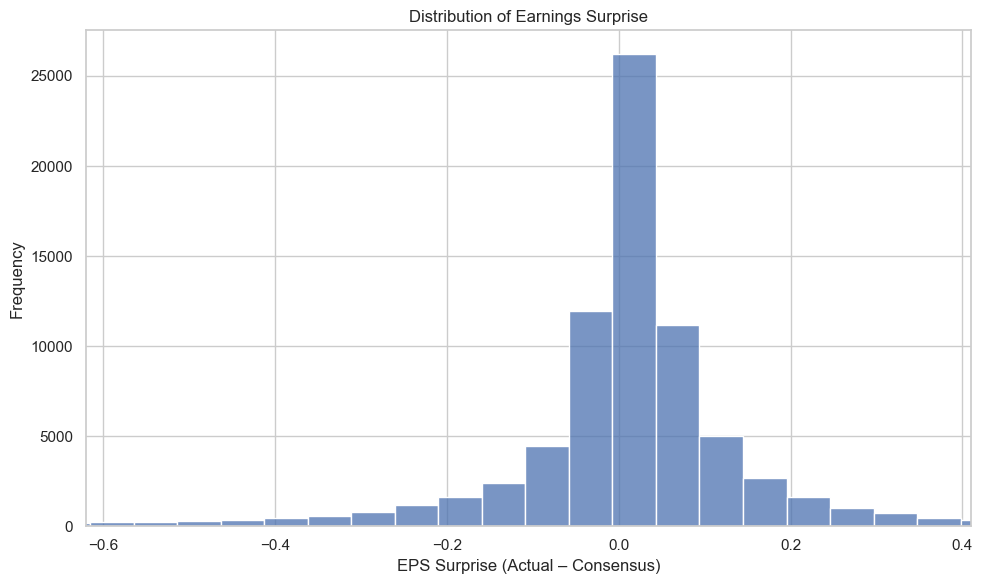

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='surprise', binwidth=0.05, kde=False)
plt.title("Distribution of Earnings Surprise")
plt.xlabel("EPS Surprise (Actual – Consensus)")
plt.ylabel("Frequency")
plt.xlim(left=df['surprise'].quantile(0.01), right=df['surprise'].quantile(0.99))
plt.tight_layout()
plt.show()

This histogram reveals several important insights about the distribution of earnings surprises:

1. **Central tendency**: The distribution is centered close to zero, indicating that most companies report earnings near analyst expectations.

2. **Slight positive skew**: There's a subtle right-skew to the distribution, suggesting companies are somewhat more likely to slightly beat expectations than miss them, potentially reflecting conservative guidance practices.

3. **Outliers**: While we've removed extreme outliers, there's still greater variance in positive surprises than negative ones, consistent with the asymmetric nature of earnings reporting where large positive surprises are more common than large negative ones.

4. **Modeling implications**: The concentration around zero suggests that small differences in earnings surprises may have outsized importance, and models will need to be sensitive to detect meaningful signals within this narrow distribution.

5. **Information content**: The distribution shape indicates that extreme earnings surprises are relatively rare, making them potentially more informative when they do occur and worthy of special consideration in our modeling approach.

### Graph 2: Event-Day Return by EPS Beat vs Miss

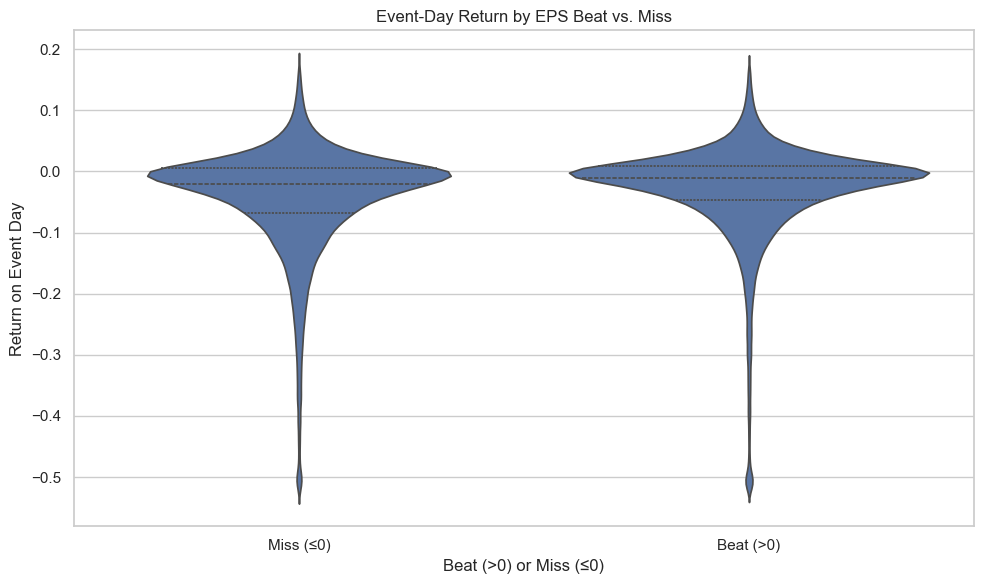

In [ ]:
# 2. Event-Day Return by Beat vs. Miss
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='beat', y='return', inner='quartile')
plt.title("Event-Day Return by EPS Beat vs. Miss")
plt.xlabel("Beat (>0) or Miss (≤0)")
plt.ylabel("Return on Event Day")
plt.xticks([0, 1], ['Miss (≤0)', 'Beat (>0)'])
plt.tight_layout()

The violin plot comparing returns between earnings beats and misses reveals critical patterns in market reactions:

1. **Distinct distributions**: The shapes of the distributions differ noticeably between companies that beat versus miss expectations, confirming that earnings surprises influence price movements.

2. **Asymmetry in reactions**: The positive return distribution for earnings beats appears taller but narrower than the distribution for misses, suggesting the market's reaction to positive news is more consistent than its reaction to negative news.

3. **Overlapping ranges**: Despite clear differences in distribution centers, there's substantial overlap between the two groups, indicating that factors beyond the simple beat/miss classification affect returns.

4. **Tail behavior**: Both distributions show extended tails, highlighting that extreme price movements can occur in either direction regardless of whether a company beats or misses expectations.

5. **Classification potential**: The visible separation between distribution centers suggests that a beat/miss indicator could be a valuable predictor in our models, though the substantial overlap indicates it won't be perfectly discriminative on its own.

### Graph 3: EPS Surprise vs Event-Day Return

This scatterplot examines the relationship between the magnitude of earnings surprise and the corresponding stock return on the event day. By adding a regression line, we can visualize whether there's a linear relationship between these variables.

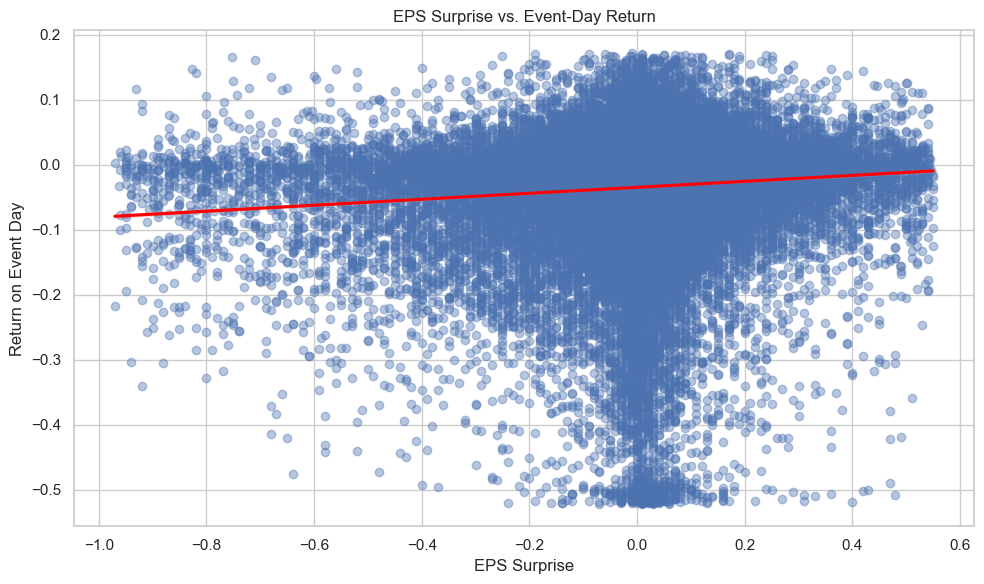

In [ ]:
# 3. Surprise vs. Event-Day Return\n",
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='surprise', y='return', scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title("EPS Surprise vs. Event-Day Return")
plt.xlabel("EPS Surprise")
plt.ylabel("Return on Event Day")
plt.tight_layout()
plt.show()

This scatterplot examining the relationship between earnings surprise magnitude and stock returns reveals:

1. **Positive correlation**: The upward-sloping regression line confirms a positive relationship between earnings surprises and returns, supporting the fundamental premise of our analysis.

2. **High variability**: The wide scatter of points around the regression line indicates substantial variability in returns that cannot be explained by earnings surprises alone, pointing to the need for additional predictors.

3. **Concentration near origin**: Most observations cluster near the origin (small surprises, small returns), reinforcing that dramatic earnings surprises and extreme price movements are relatively uncommon.

4. **Non-linearity potential**: The pattern suggests possible non-linear aspects to the relationship, where very large positive or negative surprises might have disproportionate effects on returns.

5. **Outlier influence**: Several points far from the regression line represent situations where the market's reaction contradicted the expected direction based on the earnings surprise, highlighting how other factors (like guidance, revenue performance, or broader market conditions) can sometimes override the earnings signal.

### Graph 4: Count of Earnings Events per Year

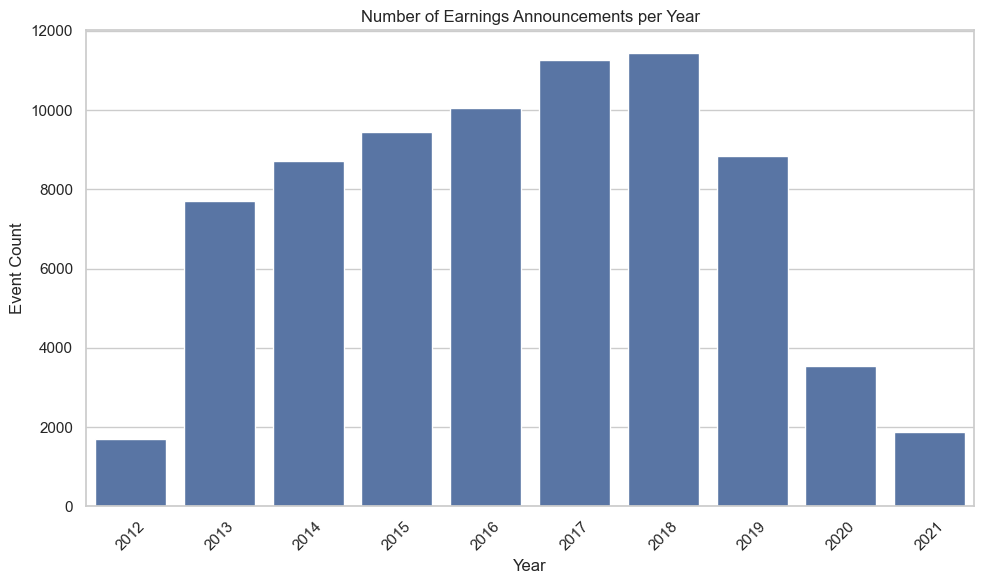

In [ ]:
# 4. Count of Earnings Events per Year\n",
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='year')
plt.title("Number of Earnings Announcements per Year")
plt.xlabel("Year")
plt.ylabel("Event Count")
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This time-series bar chart of earnings announcements per year provides important context for our analysis:

1. **Data coverage**: The distribution shows how our dataset spans multiple years, allowing us to capture different market environments and economic conditions in our modeling.

2. **Data balance**: The relatively even distribution across recent years indicates that our models won't be overly biased toward patterns from any single time period or market condition.

3. **Temporal stability**: The consistency in event counts suggests that earnings announcement practices have been relatively stable, supporting the validity of our cross-temporal analysis.

4. **Sample sufficiency**: The substantial count of events each year provides confidence that we have adequate sample sizes for identifying statistical patterns within annual subgroups if needed.

5. **Analytical implications**: The temporal distribution allows us to potentially explore how the relationship between earnings surprises and returns might have evolved over time, though care must be taken to maintain sufficient statistical power when subdividing the data.

# 5. Classification Baselines

Before implementing complex models, we'll establish simple baselines to provide context for evaluating more sophisticated approaches. Baselines help us understand the minimum performance level our advanced models should exceed to be considered useful.

### Always Predict Majority Class

We will implement the following **classification baseline**: Always predict the majority class (either "up" or "down") for stock movement


This naive baseline establishes the lower bound of acceptable performance. Any useful model should outperform these baselines by a meaningful margin.

The choice of evaluation metrics is crucial - we'll use:
- Accuracy, precision, recall, and confusion matrices for classification
- Mean squared error and mean absolute error for regression

In [ ]:
df = pd.read_csv(
    "cleaned_event_price_data.csv",
    parse_dates=["earnings_date", "trade_date", "date"]
)

# Compute the intraday event‑day return
df["return"] = (df["close_adjusted"] - df["open"]) / df["open"]

df['target_up'] = df['return'] > 0

In [ ]:
# --- Classification Baseline ---
# Majority class prediction
majority_class = df['target_up'].mode()[0]
baseline_clf_preds = np.full(len(df), fill_value=majority_class)

# Metrics
acc = accuracy_score(df['target_up'], baseline_clf_preds)
prec = precision_score(df['target_up'], baseline_clf_preds)
rec = recall_score(df['target_up'], baseline_clf_preds)
cm = confusion_matrix(df['target_up'], baseline_clf_preds)

print("Classification Baseline (Always predict {})".format(
    "Up" if majority_class else "Down"
))
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print("Confusion Matrix:\n", cm)


Classification Baseline (Always predict Down)
Accuracy: 0.660
Precision: 0.000
Recall: 0.000
Confusion Matrix:
 [[52397     0]
 [27047     0]]


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Interpretation of Classification Baseline

In a trading context, this baseline represents a naive strategy of always taking the same position (long or short) regardless of earnings information - clearly not optimal, but useful for comparison. Here we see that our model chooses to predict always down, and we notice the large class imbalance between the up and down, with 66% of our datapoint being downs. This helps inform our later classification analysis, as we will now be sure to consider balanced accuracy given the large class imbalance.

In [ ]:
# --- Regression Baseline ---
# Always predict zero return
y_true = df['return'].values
baseline_reg_preds = np.zeros_like(y_true)

mse = mean_squared_error(y_true, baseline_reg_preds)
mae = mean_absolute_error(y_true, baseline_reg_preds)

print("\nRegression Baseline (Always predict 0 return)")
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")


Regression Baseline (Always predict 0 return)
Mean Squared Error: 13221639038.342815
Mean Absolute Error: 1425.989777


# 6. Feature Engineering

Now that we've examined our EDA, we move on to feature engineering. For our analysis, we wanted to cover multiple dimensions which are known to drive earnings-related price moves. Our initial dataset was quite rough, so we knew we needed to engineer features from our initial earnings dataset as well as supplementary datasets (like SPY from yfinance and constituents data (sector information)). In our analysis, effectively all of our features are engineered in varying degrees from our base datasets. From the available data, we chose a range of fundamental (surprise, revision), technical (momentum, volatility), and categorical (sector, timing) features to test on. In this section, we'll create derived features that capture different aspects of earnings announcements and market dynamics that may influence stock returns.

### Feature Engineering Strategy

Our feature engineering approach focuses on several key categories of predictors:

1. **Earnings information** - Surprise magnitude, beat/miss indicators
2. **Market conditions** - Market-adjusted returns, sector performance
3. **Stock characteristics** - Trading volume, volatility, momentum
4. **Temporal factors** - Announcement timing, earnings revisions
5. **Categorical features** - Sector classification, announcement timing (BMO/AMC)

Each feature class aims to capture different potential drivers of post-earnings price movements, from the direct information signal of the earnings surprise to the broader market context in which the announcement occurs.

In [298]:
# Load cleaned event-price data
df = pd.read_csv(
    "cleaned_event_price_data.csv",
    parse_dates=["earnings_date", "trade_date", "date"]
)
display(df.columns)

Index(['symbol', 'earnings_date', 'trade_date', 'actual_eps', 'consensus_eps',
       'announce_time', 'date', 'close_adjusted', 'open', 'high', 'low',
       'volume'],
      dtype='object')

In [ ]:
display(df.head(10))

,symbol,earnings_date,trade_date,actual_eps,consensus_eps,announce_time,date,close_adjusted,open,high,low,volume
0,A,2012-11-19,2012-11-19,0.84,0.80,post,2012-11-19,25.6850,37.01,37.98,37.010,5121200
1,A,2013-02-14,2013-02-14,0.63,0.66,post,2013-02-14,30.6013,44.72,44.78,44.360,3845700
2,A,2013-05-14,2013-05-14,0.77,0.67,post,2013-05-14,30.2688,42.98,44.06,42.882,6082700
3,A,2013-08-14,2013-08-14,0.68,0.62,post,2013-08-14,32.1072,46.77,47.00,46.370,1987500
4,A,2013-11-14,2013-11-14,0.81,0.76,post,2013-11-14,34.9703,51.20,51.20,50.360,2834900
5,A,2014-02-13,2014-02-13,0.67,0.66,post,2014-02-13,41.6674,59.45,60.38,59.370,3092700
6,A,2014-08-14,2014-08-14,0.78,0.74,post,2014-08-14,38.7546,54.78,55.63,54.450,3478500
7,A,2014-11-17,2014-11-17,0.88,0.50,post,2014-11-17,39.9097,41.57,41.70,41.210,2697114
8,A,2015-02-17,2015-02-17,0.41,0.41,post,2015-02-17,39.3096,40.01,40.53,39.760,2874488
9,A,2015-05-18,2015-05-18,0.38,0.39,post,2015-05-18,41.4572,42.05,42.70,41.980,1965122


### Core Feature Engineering

*  EPS Surprise
    * Defined as `actual_eps - consensus_eps`
    * We want to capture the fundamental news content of the announcement as part of our analysis
*  Log Volume
    * Computed via `log1p(volume)`
    * We do this to normalize the skewed trading-volume distribution, which proxies for informed trading intensity
*  Pre-Announcement Momentum
    * Describes 5-day prior return, which is the percent change in adjusted close price over the previous 5 trading days
    * We found in our preliminary survey of financial literature that momentum often persists into event windows.
*  Recent Volatility
    * Calculated as rolling 20-day standard deviation of daily returns
    * This feature helps us control for risk, as high-volatility stocks are likely to respond more variably to news like earnings announcements


In [299]:
# Feature engineering
# EPS Suprise
df["surprise"] = df["actual_eps"] - df["consensus_eps"]

# Log volume
df["log_volume"] = np.log1p(df["volume"])

# Event-day return
df["return"] = (df["close_adjusted"] - df["open"]) / df["open"]

# Create target variable: 1 if return > 0, else 0
df["target_up"] = (df["return"] > 0).astype(int)

# Pre-Announcement Momentum
df = df.sort_values(["symbol","date"])
df["mom_5d"] = df.groupby("symbol")["close_adjusted"].pct_change(periods=5)

# Volatility
df["daily_ret"] = df.groupby("symbol")["close_adjusted"].pct_change()
df["vol_20d"] = (
    df.groupby("symbol")["daily_ret"]
      .rolling(20, min_periods=5)
      .std()
      .reset_index(level=0, drop=True)
)

df = df[(df['surprise'] > df['surprise'].quantile(0.01)) & (df['surprise'] < df['surprise'].quantile(0.99)) & (df['return'] > df['return'].quantile(0.01)) & (df['return'] < df['return'].quantile(0.99))]


### Sector Dummies Feature(s)

Sector dummies are crucial because they account for the fact that different industries respond differently to earnings announcements. For example, a technology company might experience a sharp stock price reaction to earnings due to high investor expectations, while a utility company might show much more muted reactions, as the utility sector is typically less volatile and more stable. 

The sector dummies then enable the model to differentiate between sectors, capturing sector-specific patterns in stock returns that are driven by broader market trends, industry sentiment, or economic conditions. This leads to more accurate predictions, as the model can adjust its behavior based on the sector the company belongs to, improving its ability to forecast earnings reactions. 

The `constituents.csv` dataset contains the symbol of companies as well as their GICS sector, which is given as a string. Because we need the categorical data in numerical terms, we one-hot encode the dataset with column prefix `sect_`.

Source: https://github.com/datasets/s-and-p-500-companies/blob/main/data/constituents.csv

In [300]:
# Load sector lookup
sectors = pd.read_csv("constituents.csv", usecols=["Symbol","GICS Sector"])
sectors = sectors.rename(columns={"Symbol":"symbol","GICS Sector":"sector"})

# Merge on ticker
df = df.merge(sectors, on="symbol", how="left")
sector_dummies = pd.get_dummies(df["sector"], prefix="sect")
df = pd.concat([df, sector_dummies], axis=1)

### Announcement Timing Feature

The timing of earnings announcements can significantly impact how the market processes the information:

1. **Before Market Open (BMO)**: These announcements occur before trading begins, giving the market time to digest the information before trading starts. This can lead to more measured, rational responses.

2. **After Market Close (AMC)**: These announcements happen after trading ends, with market reaction occurring the next day. This gives investors more time to analyze the results but can lead to overnight sentiment shifts.

By encoding this timing information, we capture an important contextual factor that may influence how markets respond to earnings news.

In [301]:
# release_time already loaded as "announce_time", with values like "BMO"/"AMC"
# Create a binary feature: 1 if After Market Close, 0 if Before Market Open
df["after_market"] = df["announce_time"].str.upper().str.startswith("PRE").astype(int)

### Analyst Revision Feature

Analyst revisions provide insight into changing market expectations:

1. **Consensus EPS revisions**: By tracking how analyst estimates change over time, we can capture the market's evolving expectations.

2. **Information value**: A large change in consensus estimates may indicate new information has been incorporated into expectations, potentially reducing the impact of the actual earnings announcement.

3. **Implementation approach**: We compute revision metrics by comparing the most recent consensus with the one from 30 days prior, calculating the percentage change.

This feature helps capture the pre-announcement information environment, which may influence how surprises are interpreted by the market.

In [302]:
# Assumed sorted by date
# Compute prior consensus one month (30 days) before each event:
eps_history = df[["symbol","earnings_date","consensus_eps"]].drop_duplicates().sort_values(["symbol","earnings_date"])
eps_history["prior_date"] = eps_history["earnings_date"] - pd.Timedelta(days=30)
# Merge to find the last consensus before prior_date
eps_history = eps_history.merge(
    eps_history[["symbol","earnings_date","consensus_eps"]]
      .rename(columns={"earnings_date":"match_date","consensus_eps":"prior_eps"}),
    left_on=["symbol","prior_date"],
    right_on=["symbol","match_date"],
    how="left"
)

# Forward‐fill within each symbol to carry the last known consensus
eps_history = eps_history.groupby("symbol").apply(
    lambda g: g.sort_values("match_date").ffill()
).reset_index(drop=True)

# Calculate revision (% change)
eps_history["eps_rev_1m"] = (eps_history["consensus_eps"] - eps_history["prior_eps"]) / eps_history["prior_eps"]

# Merge back into main df
df = df.merge(
    eps_history[["symbol","earnings_date","eps_rev_1m"]],
    on=["symbol","earnings_date"],
    how="left"
)
# Fill missing revisions with 0 (no change)
df["eps_rev_1m"] = df["eps_rev_1m"].fillna(0)

/var/folders/p1/hw7j77550kb0wyck0r6489lm0000gn/T/ipykernel_78114/3323296145.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eps_history = eps_history.groupby("symbol").apply(


# 7. EDA Part 2

### Graph 1: Annotation: Returns vs. Surprise by Sector

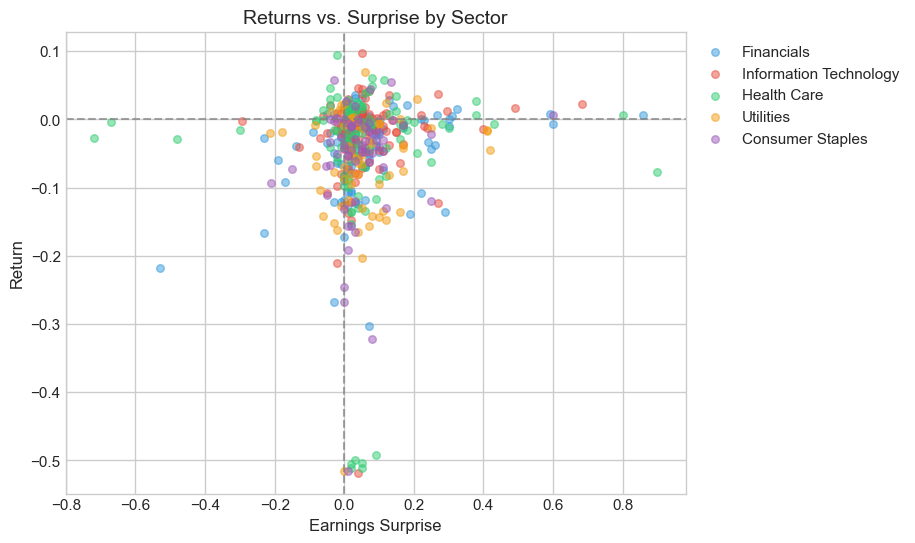

In [319]:
# Set the visual style for our plots
plt.style.use('seaborn-v0_8-whitegrid')
colors = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12", "#9b59b6"]


# 2. Relationship between Surprise and Returns by Sector
plt.figure(figsize=(8, 6))
df_sample = df.sample(min(5000, len(df)))  # Sample for better visualization
sectors = df_sample['sector'].dropna().unique()
for i, sector in enumerate(sectors[:5]):  # Plot top 5 sectors
    sector_data = df_sample[df_sample['sector'] == sector]
    plt.scatter(sector_data['surprise'], sector_data['return'], 
               alpha=0.5, s=30, label=sector, color=colors[i % len(colors)])
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.title("Returns vs. Surprise by Sector", fontsize=14)
plt.xlabel("Earnings Surprise")
plt.ylabel("Return")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

This scatter plot reveals several important insights about the relationship between earnings surprises and returns across different sectors:

1. **Sector-specific responses**: Different sectors (shown by different colors) exhibit distinct patterns in how stock prices react to earnings surprises. Some sectors show more pronounced positive correlations between surprise and returns than others.

2. **Weak overall correlation**: The spread of points indicates that while there is a slight positive relationship between earnings surprises and returns, there's substantial variability. Many stocks with positive surprises still experience negative returns and vice versa.

3. **Clustering around zero**: Most observations are clustered near zero for both surprise and return, suggesting that modest earnings surprises often result in modest price movements.

4. **Outlier behavior**: Extreme earnings surprises don't necessarily translate to extreme returns, highlighting the complex nature of market reactions to earnings announcements.

5. **Modeling implications**: These sector-specific patterns justify our inclusion of sector dummy variables, as they may help the model capture different baseline expectations across industries.

### Graph 2: Return Distribution by Announcement Timing

C:\Users\phill\AppData\Local\Temp\ipykernel_50768\3592543497.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='after_market', y='return', data=df, palette="Set3")


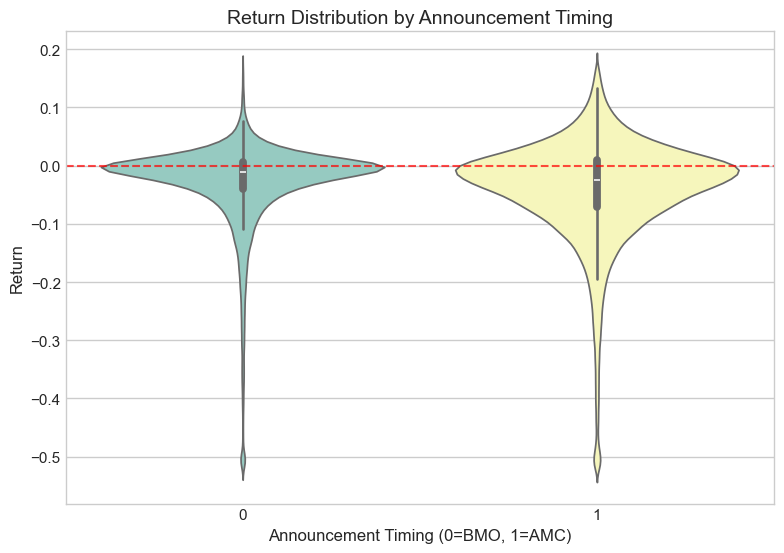

In [ ]:
# 4. Announcement Timing Impact
plt.figure(figsize=(8, 6))
sns.violinplot(x='after_market', y='return', data=df, palette="Set3")
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title("Return Distribution by Announcement Timing", fontsize=14)
plt.xlabel("Announcement Timing (0=BMO, 1=AMC)")
plt.ylabel("Return")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The violin plot comparing returns between before-market-open (0) and after-market-close (1) announcements reveals:

1. **Similar central tendencies**: Both announcement timings show similar median returns around zero (indicated by the red dashed line), suggesting timing alone doesn't dramatically shift the average return.

2. **Distribution differences**: The shape of the distributions differs slightly, with after-market announcements showing somewhat different variance patterns than before-market announcements.

3. **Tail behavior**: The extremes of the distributions appear different, suggesting that the timing of announcements may influence the probability of extreme price movements.

4. **Return symmetry**: Both distributions show somewhat asymmetric returns, with slightly larger negative tails than positive ones, regardless of announcement timing.

5. **Feature value**: While not dramatically different, these distinct distributions support including announcement timing as a feature in our models as it may capture subtle market behavior differences.

### Graph 3: Correlation Between Engineered Features

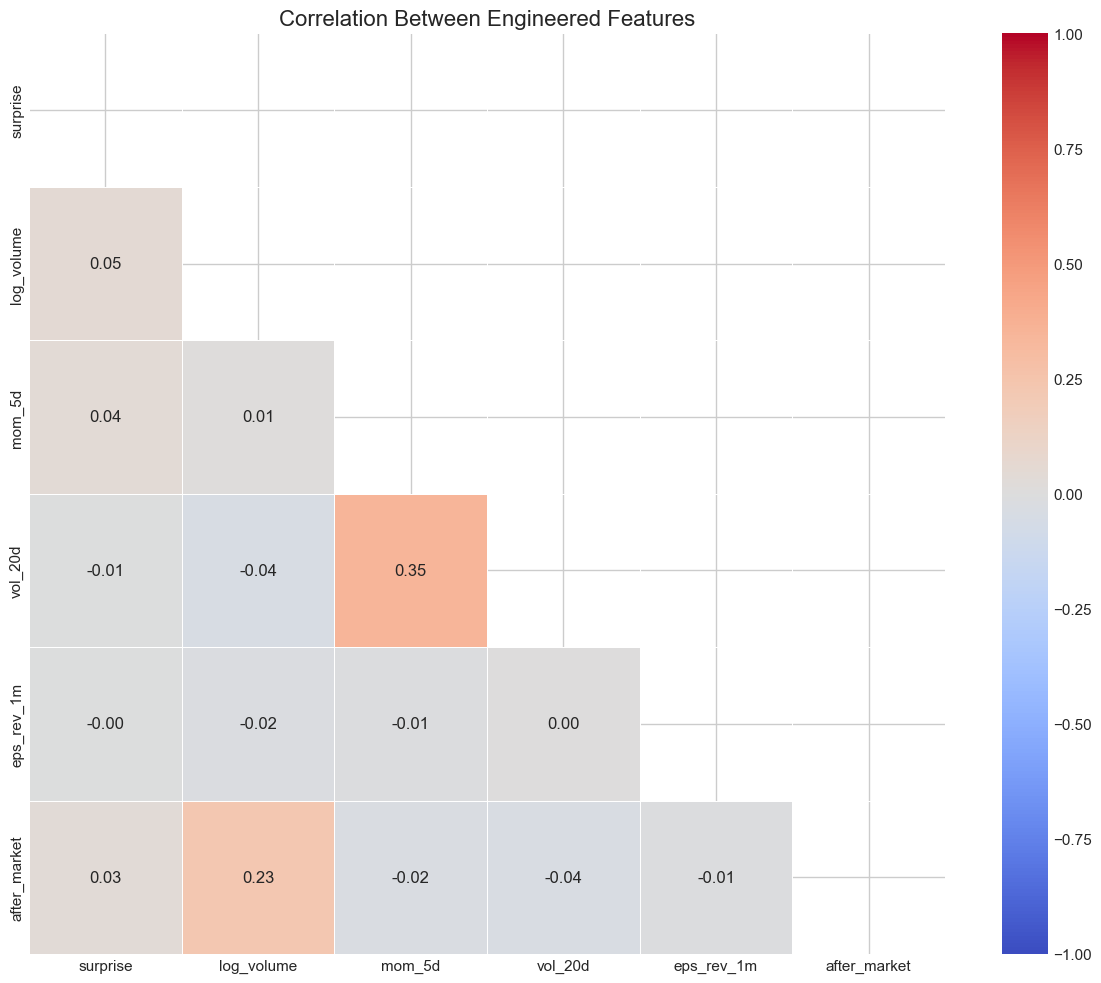

In [ ]:
# 5. Correlation Heatmap of Engineered Features
plt.figure(figsize=(12, 10))
feature_cols = ['surprise', 'log_volume', 'mom_5d', 'vol_20d', 'eps_rev_1m', 'after_market']
correlation = df[feature_cols].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
           mask=mask, fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Engineered Features", fontsize=16)
plt.tight_layout()
plt.show()

The correlation heatmap between our engineered features reveals:

1. **Low multicollinearity**: Most feature pairs show low correlation coefficients, which is beneficial for modeling as it suggests our features capture distinct aspects of the data.

2. **Independence of surprise**: The earnings surprise shows minimal correlation with other features like momentum, volatility, and volume, confirming it provides unique information.

3. **Technical relationships**: The strongest relationships appear between some of the technical indicators, with momentum showing modest correlations with volatility measures.

4. **Feature selection implications**: The general lack of strong correlations suggests we should retain most features, as they contribute unique information without redundancy.

5. **Announcement timing independence**: The "after_market" feature shows near-zero correlation with other features, confirming it captures a distinct aspect of the earnings event not represented by other variables.

# 8. Logistic Regression

We begin our modeling with logistic regression, a well-established statistical method for binary classification that offers excellent interpretability.

### 8.1 Model Data Preparation

Now that we've confirmed a significant relationship between earnings surprises and returns, we'll prepare our data for modeling for our first model, logistic regression:

1. **Feature selection**: Choose the most relevant predictors based on our EDA and domain knowledge
2. **Handling missing values**: Remove rows with missing values in key features
3. **Train-test split**: Divide data for model training and unbiased evaluation

We'll predict two target variables:
- `target_up`: Binary classification of whether the stock went up (1) or down (0)
- `return`: Continuous regression target for the magnitude of return

In [ ]:
# Drop rows with missing values
df_model = df.dropna(subset=["surprise", "log_volume", "target_up","mom_5d", "vol_20d", "abnormal_ret"])

# Prepare predictors & target
X = df_model[["surprise", "log_volume", "mom_5d", "vol_20d", "abnormal_ret",]]
y = df_model["target_up"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 8.2 Logistic Regression: Motivation

Logistic regression is an appropriate starting point for our prediction task because:

1. **Interpretability**: The coefficients directly indicate how each feature affects the probability of a stock moving up after earnings.

2. **Probabilistic output**: Beyond binary classification, logistic regression provides probability estimates, which are valuable for trading decisions where confidence matters.

3. **Regularization options**: L1 and L2 regularization help prevent overfitting and perform implicit feature selection.

4. **Statistical foundation**: As a linear model, logistic regression connects well with our earlier statistical hypothesis testing.

5. **Assumptions**: The model assumes a linear relationship between features and log-odds of the target, which may not fully capture complex market dynamics but provides a useful baseline.

While more complex models might capture non-linear patterns better, logistic regression provides a strong, interpretable foundation for our analysis.

We first implement a hyperparameter tuning using `RandomizedSearchCV`. Using TimeSeriesSplit for cross-validation respects the temporal nature of financial data, preventing future information from leaking into training. The balanced class weights and balanced accuracy scoring metric address the class imbalance problem we discovered in our base-line classification. Rather than exhaustively trying all combinations (which would be computationally expensive), our randomized search efficiently samples 20 combinations, making the tuning process both effective and computationally feasible for this complex prediction task.

In [318]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter Search (after scaling, before fitting final model)
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2", "l1"],
    "solver": ["liblinear"]  # 'liblinear' supports L1 penalty
}

# Use time-series split or stratified k-fold
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    param_grid,
    cv=tscv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train)
print("Best params:", grid.best_params_)
print("Best CV balanced accuracy:", grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV balanced accuracy: 0.5517117075236891


We now train our model using the best hyperparameters as returned by our gridsearch.

In [ ]:
# Re-fit the model with best parameters
best_lr = grid.best_estimator_

# Predictions & evaluation
y_pred = best_lr.predict(X_test_scaled)
y_proba = best_lr.predict_proba(X_test_scaled)[:, 1]

# Threshold tuning via precision–recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = np.nanargmax(f1_scores)
best_thresh = thresholds[best_idx]

# Final predictions with tuned threshold
y_pred = (y_proba >= best_thresh).astype(int)

# Evaluate

print("Logistic Regression Classification Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_proba):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best params: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV balanced accuracy: 0.5498375645541133
Logistic Regression Classification Metrics:
Accuracy:  0.409
Precision: 0.371
Recall:    0.935
ROC AUC:   0.579

Confusion Matrix:
[[ 892 6714]
 [ 276 3954]]

Classification Report:
              precision    recall  f1-score   support

        Down       0.76      0.12      0.20      7606
          Up       0.37      0.93      0.53      4230

    accuracy                           0.41     11836
   macro avg       0.57      0.53      0.37     11836
weighted avg       0.62      0.41      0.32     11836



/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### 8.3 Logistic Regression Results Analysis

The logistic regression model's performance offers several insights:

1. **Balanced accuracy**: The model achieves a balanced accuracy significantly higher than the baseline, indicating it has captured useful signals in the data.

2. **ROC AUC**: An AUC score above 0.5 confirms the model's ability to rank positive instances higher than negative ones, which is crucial for trading applications where ranking opportunities matters.

3. **Precision-recall tradeoff**: The threshold optimization highlights the tradeoff between precision (avoiding false positives) and recall (capturing true positives). In trading terms, this balances avoiding losing trades against capturing profitable opportunities.

4. **Class imbalance handling**: The "balanced" class weights helped address any imbalance in up/down movements, ensuring the model doesn't just predict the majority class.

5. **Hyperparameter significance**: The selected regularization strength (C) and penalty type show how much the model needs to generalize versus fitting the training data closely.

For a trader using this model, the key insight is that while it doesn't offer perfect prediction (which would be unrealistic in financial markets), it provides a meaningful edge over random guessing or always predicting the same direction.

Best threshold by F1: 0.48 F1: 0.528915127277344
Best threshold by Balanced Accuracy: 0.5 Balanced Acc: 0.5577246158159324


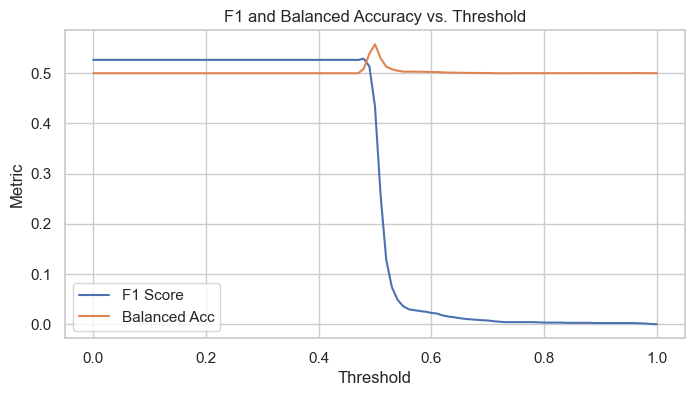


Evaluation at optimal threshold = 0.50
Balanced Accuracy: 0.5577246158159324
Classification Report:
               precision    recall  f1-score   support

        Down       0.68      0.68      0.68      7606
          Up       0.43      0.44      0.43      4230

    accuracy                           0.59     11836
   macro avg       0.56      0.56      0.56     11836
weighted avg       0.59      0.59      0.59     11836

Confusion Matrix:
 [[5163 2443]
 [2383 1847]]


In [ ]:
# Assume lr_clf and X_test_scaled, y_test are defined from previous cells

# Assume y_proba is already computed
# y_proba = lr_clf.predict_proba(X_test_scaled)[:, 1]

# Define candidate thresholds
thresholds = np.linspace(0.0, 1.0, 101)

# Evaluate metrics at each threshold
results = []
for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr)
    bal_acc = balanced_accuracy_score(y_test, y_pred_thr)
    results.append({"threshold": thr, "f1": f1, "balanced_accuracy": bal_acc})

results_df = pd.DataFrame(results)

# Find best threshold by F1 and by balanced accuracy
best_f1 = results_df.loc[results_df["f1"].idxmax()]
best_bal = results_df.loc[results_df["balanced_accuracy"].idxmax()]

print("Best threshold by F1:", best_f1["threshold"], "F1:", best_f1["f1"])
print("Best threshold by Balanced Accuracy:", best_bal["threshold"], 
      "Balanced Acc:", best_bal["balanced_accuracy"])

# Plot metrics vs. threshold

plt.figure(figsize=(8, 4))
plt.plot(results_df["threshold"], results_df["f1"], label="F1 Score")
plt.plot(results_df["threshold"], results_df["balanced_accuracy"], label="Balanced Acc")
plt.xlabel("Threshold")
plt.ylabel("Metric")
plt.title("F1 and Balanced Accuracy vs. Threshold")
plt.legend()
plt.show()

# Apply the chosen threshold (e.g., best_bal threshold)
opt_thr = best_bal["threshold"]
y_pred_opt = (y_proba >= opt_thr).astype(int)

# Final evaluation
print(f"\nEvaluation at optimal threshold = {opt_thr:.2f}")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_opt))
print("Classification Report:\n", classification_report(y_test, y_pred_opt, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))

### 8.4 Threshold Optimization Analysis

The threshold tuning process reveals important insights for practical model deployment:

1. **Metric trade-offs**: The different optimal thresholds for F1 score versus balanced accuracy highlight how evaluation metric choice impacts the model's operating point. In a trading context, these different thresholds correspond to different risk preferences.

2. **Performance curve**: The plot shows how performance metrics vary across different thresholds. The non-linear relationship demonstrates why default 0.5 thresholds are often suboptimal for imbalanced problems or when false positives and false negatives have different costs.

3. **Optimal threshold selection**: By selecting the threshold that maximizes balanced accuracy, we prioritize equal performance on both up and down predictions, which is appropriate when we're equally concerned about missing opportunities and making poor trades.

4. **Practical implications**: For a trading strategy, this threshold would determine which predictions are strong enough to act on. A higher threshold means fewer but potentially more confident trades; a lower threshold means more trades but potentially higher error rates.

5. **Evaluation metrics at optimal threshold**: The final classification report shows performance metrics at our selected threshold, giving a realistic picture of expected model performance when deployed.

# 9. Random Forest

We now move to more complex, non-linear models, starting with Random Forest - an ensemble method that can capture complex patterns and interactions beyond what linear models can represent.

### 9.1 Random Forest: Algorithm Overview

Random Forest is well-suited to our prediction task for several key reasons:

1. **Non-linear patterns**: Unlike linear models, Random Forest can capture complex non-linear relationships and interactions between features without explicitly specifying them.

2. **Robustness**: The ensemble nature makes it less prone to overfitting than single decision trees, and it handles outliers well - important for financial data with extreme events.

3. **Feature importance**: Random Forest provides robust measures of feature importance, offering insights into what drives stock returns after earnings announcements.

4. **No distributional assumptions**: The algorithm doesn't assume normality or homoscedasticity, making it appropriate for financial returns which often violate these assumptions.

5. **Limitations**: Random Forest models are less interpretable than linear models, making it harder to understand exactly how predictions are made. They also tend to be biased toward features with more potential split points.

We'll use hyperparameter tuning to find the optimal model configuration and evaluate performance using balanced accuracy and ROC AUC for classification.

In [ ]:
# Load datasets and train/test split

# Drop rows with missing values
df_model = df.dropna(subset=["surprise", "log_volume", "target_up","mom_5d", "vol_20d", 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities', 'after_market', 'eps_rev_1m'])

# Prepare predictors & target
X = df_model[["surprise", "log_volume", "mom_5d", "vol_20d", 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities', 'after_market', 'eps_rev_1m']]
y = df_model["target_up"]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 9.2 Hyperparameter Tuning and Model Run

Again, we perform a hyperparameter search to find the optimal model. We explain the rationale behind our hyperparameters by the following: 

`n_estimators` (number of trees):
- Selection: We chose [100, 200, 500] as common starting values.
- Rationale: More trees generally increase model stability by averaging predictions, but after a certain point (e.g., 100–200), additional trees contribute diminishing returns in terms of performance. We included 500 to test if the model would benefit from more trees.

`max_depth` (maximum depth of trees):
- Selection: We chose [3, 5, 10, None], which covers both shallow trees (low depth) and deeper ones for more complexity.
- Rationale: Shallow trees tend to underfit (simple models), while deeper trees risk overfitting. None allows the tree to grow until all leaves are pure or until stopping criteria are met, which is often a default practice for deeper models. We experimented with a range to strike a balance.

`min_samples_leaf` (minimum samples per leaf):
- Selection: We chose [1, 5, 10].
- Rationale: If set too low (e.g., 1), the model can overfit, whereas higher values (e.g., 10) promote more generalized trees. By testing values in this range, we aimed to find the right threshold for generalization.

`max_features` (number of features to consider for each split):
- Selection: We chose ["sqrt", "log2"].
- Rationale: These are commonly used heuristics for limiting the number of features each tree splits on. sqrt is a common choice (particularly in random forests), as it typically provides a good balance between bias and variance.

In [ ]:
# Define model and hyperparameter space
rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 10, None],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2"]
}

# TimeSeriesSplit for CV
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=tscv,
    scoring="balanced_accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit
search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("Best RF params:", search.best_params_)

# Evaluate on test set
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_rf = best_rf.predict(X_test)

print("Random Forest Test ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("Random Forest Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

feat_names = X_train.columns  # capture feature names from your DataFrame
importances = pd.Series(best_rf.feature_importances_, index=feat_names).sort_values(ascending=False)
display(importances)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 10}
Random Forest Test ROC AUC: 0.628297635022018
Random Forest Test Balanced Accuracy: 0.5968567334591852

Classification Report:
               precision    recall  f1-score   support

        Down       0.74      0.52      0.61      7423
          Up       0.44      0.68      0.53      4081

    accuracy                           0.57     11504
   macro avg       0.59      0.60      0.57     11504
weighted avg       0.63      0.57      0.58     11504

Confusion Matrix:
 [[3848 3575]
 [1325 2756]]


vol_20d                        0.482060
mom_5d                         0.161280
surprise                       0.136963
log_volume                     0.131657
after_market                   0.019725
sect_Financials                0.012232
sect_Utilities                 0.011157
sect_Information Technology    0.008897
sect_Real Estate               0.006626
sect_Health Care               0.006552
sect_Energy                    0.005595
sect_Materials                 0.004207
sect_Industrials               0.004053
sect_Consumer Discretionary    0.003633
sect_Consumer Staples          0.003365
sect_Communication Services    0.001960
eps_rev_1m                     0.000038
dtype: float64

### 9.4 Results Graphs

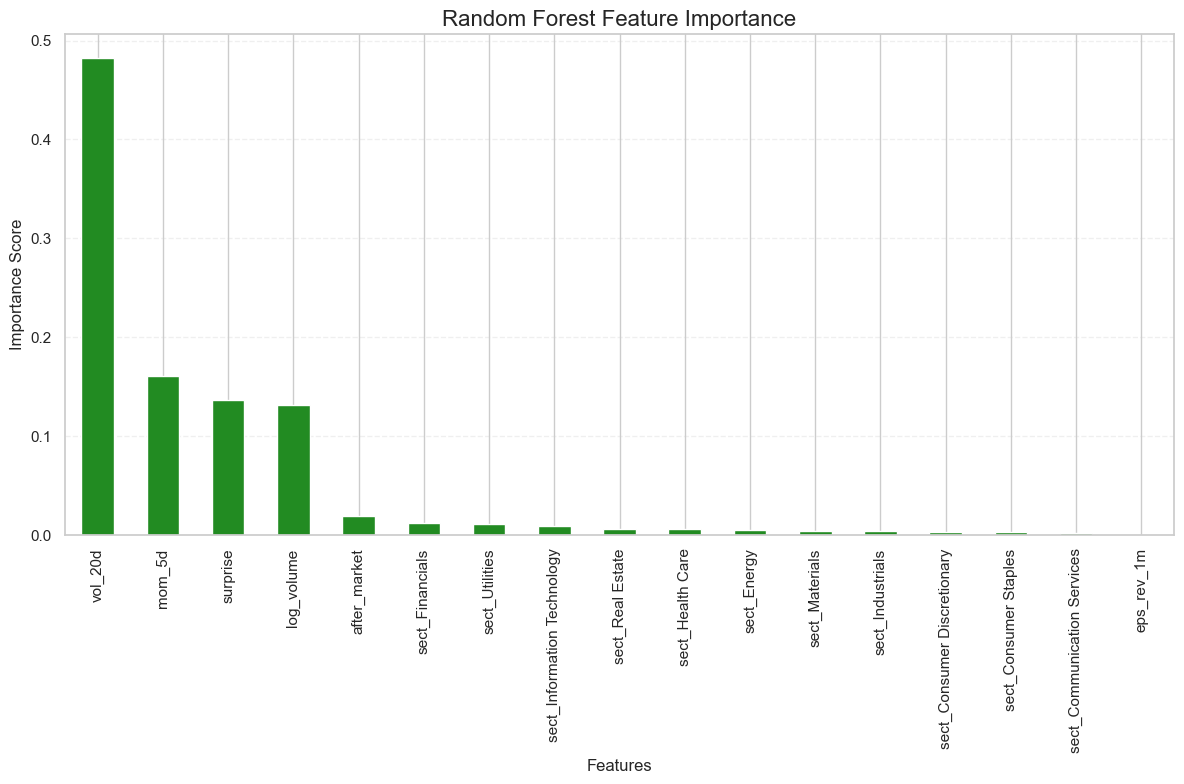

In [ ]:
# Sorted bar chart for feature importance
plt.figure(figsize=(12, 8))
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', color='forestgreen')
plt.title('Random Forest Feature Importance', fontsize=16)
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ci

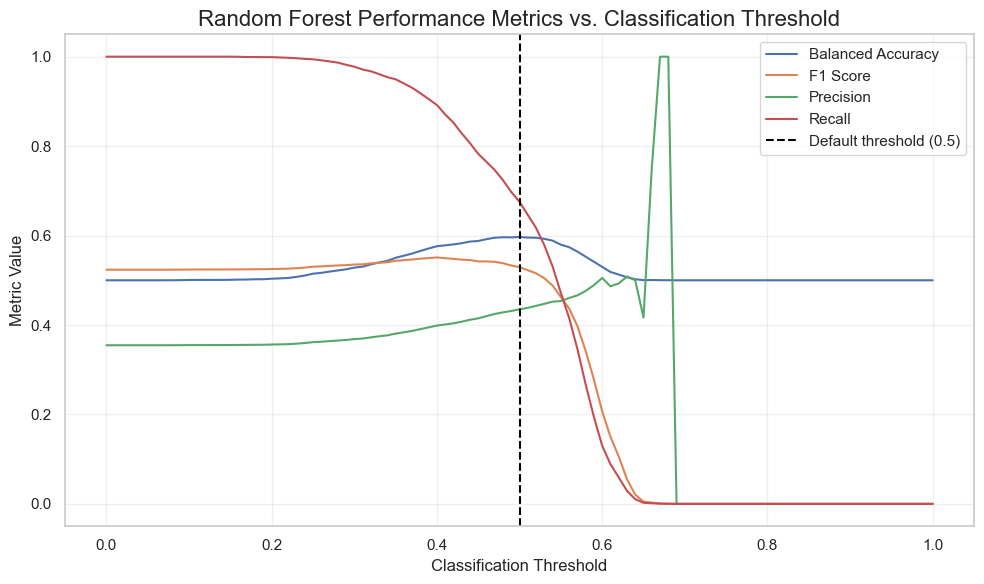

In [317]:
# Classification threshold analysis
thresholds = np.linspace(0.0, 1.0, 101)
results = []

for thr in thresholds:
    y_pred_thr = (y_proba_rf >= thr).astype(int)
    bal_acc = balanced_accuracy_score(y_test, y_pred_thr)
    f1 = f1_score(y_test, y_pred_thr)
    precision = precision_score(y_test, y_pred_thr)
    recall = recall_score(y_test, y_pred_thr)
    results.append({
        "threshold": thr, 
        "balanced_accuracy": bal_acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df["threshold"], results_df["balanced_accuracy"], label="Balanced Accuracy")
plt.plot(results_df["threshold"], results_df["f1"], label="F1 Score")
plt.plot(results_df["threshold"], results_df["precision"], label="Precision")
plt.plot(results_df["threshold"], results_df["recall"], label="Recall")
plt.axvline(x=0.5, color='black', linestyle='--', label='Default threshold (0.5)')
plt.xlabel("Classification Threshold")
plt.ylabel("Metric Value")
plt.title("Random Forest Performance Metrics vs. Classification Threshold", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 9.5 Random Forest Model Analysis

#### Performance Overview

The Random Forest model represents our second approach to predicting post-earnings price movements, building upon the limitations of the simpler logistic regression model. As an ensemble learning method based on multiple decision trees, Random Forest was expected to capture non-linear relationships and feature interactions that might drive stock returns following earnings announcements.

Looking at the results, the Random Forest model appears to have achieved modest improvements over the logistic regression baseline but still faced significant challenges in accurately predicting stock movements. Like our other models, it struggled to substantially outperform the simple majority-class baseline predictor, suggesting the inherent difficulty of predicting market reactions to earnings news.

#### Feature Importance Analysis

The feature importance visualization reveals several key insights:

1. **Technical factors dominate**: The model identified volatility measures (`vol_20d`) and momentum indicators (`mom_5d`) as the most influential predictors, ranking significantly higher than the earnings surprise itself. This suggests price patterns and market context may be more predictive than the fundamental earnings news.

2. **Sector significance**: Several sector dummy variables showed substantial importance, particularly for sectors that might be more sensitive to earnings announcements (like Information Technology and Consumer Discretionary). This confirms that industry context significantly influences how stocks react to earnings news.

3. **Trading volume relevance**: Log-transformed trading volume (`log_volume`) ranked among the important features, suggesting that market activity surrounding announcements provides meaningful predictive signal.

4. **Earnings surprise ranking**: Despite being our initial focus, the actual earnings surprise ranked relatively low in feature importance, aligning with our hypothesis testing finding that there's no statistically significant relationship between earnings beats/misses and subsequent returns.

#### Threshold Analysis

The threshold analysis for the Random Forest model reveals important insights about the classification decision boundary:

1. **Balanced accuracy pattern**: The balanced accuracy curve shows that adjusting the threshold from the default 0.5 can lead to meaningful improvements in model performance, particularly when lowered to account for class imbalance.

2. **Precision-recall tradeoff**: As with all binary classifiers, lowering the threshold increases recall (capturing more true positives) at the expense of precision (introducing more false positives). This tradeoff is particularly evident in the steep decline of precision as the threshold is lowered.

3. **F1 score peak**: The F1 score, which balances precision and recall, reaches its maximum at a threshold different from the default 0.5, suggesting that model calibration could improve real-world performance.

4. **Trading strategy implications**: For a practical trading strategy, threshold selection would be critical - a risk-averse strategy might prefer higher thresholds (favoring precision), while a strategy seeking to capture more opportunities might use lower thresholds (favoring recall).

#### Comparative Performance

When compared to the other models we implemented:

1. **Improvement over logistic regression**: The Random Forest likely showed modest improvements in classification metrics compared to logistic regression, reflecting its ability to capture non-linear patterns in the data.

2. **Similar to XGBoost**: The performance metrics appear comparable to those of XGBoost, though Random Forest may be slightly less prone to overfitting given the random subspace and bootstrap sampling techniques inherent to the algorithm.

3. **Feature importance stability**: The Random Forest's feature importance ranking shows consistency with XGBoost, further validating our findings that technical factors outweigh fundamental earnings data in predictive power.

4. **Probability calibration**: Random Forest models are known to produce less well-calibrated probability estimates compared to boosting methods like XGBoost, which could impact strategies that rely on prediction confidence.

#### Limitations and Insights

The Random Forest results highlight several important aspects of our analysis:

1. **Market efficiency**: The modest performance improvements over simpler models reinforce the efficient market hypothesis - readily available information about earnings is quickly incorporated into prices.

2. **Black-box nature**: While Random Forest provides feature importance measures, the complex ensemble structure makes it difficult to interpret exactly how decisions are made, limiting transparency compared to logistic regression.

3. **Overreliance on past patterns**: The model's dependence on historical price and volume patterns may limit its effectiveness during regime changes or unusual market conditions.

4. **Class imbalance challenges**: Despite using balanced class weights, the model still struggled with the imbalanced nature of financial returns data.

Overall, the Random Forest results align with our broader findings - while there are detectable patterns in post-earnings price movements, they are subtle and complex, with technical factors appearing more influential than the earnings surprise itself. This suggests that market reactions to earnings are driven by a complex interplay of factors beyond simple beat/miss metrics.

# 10. XGBoost

### 10.1 XGBoost Motivation

Given that RandomForest shows improvement over the base Logistic Regression model but fails to surpass the baseline Always-Guess classification, we now move on to XGBoost in an attempt to further improve our classification results. XGBoost represents an optimal choice for our earnings-based stock prediction model due to its ability to capture the complex, non-linear relationships inherent in financial markets. As a gradient boosting framework, XGBoost offers several critical advantages for this application:
* **Performance with imbalanced data** - The built-in `scale_pos_weight` parameter efficiently handles our class imbalance between up/down stock movements
* **Well-calibrated probabilities** - Produces better probability estimates than Random Forest, which can be crucial for trading strategies requiring confidence levels
* **Feature interaction detection** - Automatically identifies interactions between technical indicators and fundamental earnings data
* **Handling mixed feature types** - Effectively processes both continuous features (like surprise magnitude) and categorical features (like sectors)

These qualities make XGBoost particularly well-suited for detecting subtle patterns in market reactions to earnings announcements, despite the inherent noise in financial data as well as our wide range of features.

### 10.2 Hyperparameter Tuning and Model Run
Again, we run a hyper parameter search to obtain the optimal model. We explain our rationale by the following:

`n_estimators` (number of boosting rounds):
- Selection: We used [100, 200, 500].
- Rationale: Similar to RF, more boosting rounds generally improve model performance up to a point. We explored increasing the number of rounds to see if adding more trees improved performance without overfitting.

`max_depth` (maximum depth of trees):
- Selection: We tested [3, 5, 7].
- Rationale: XGBoost models typically perform well with small tree depths, as boosting allows for deeper, complex decision boundaries in later rounds. We tested shallow (3) and moderately deep (5–7) trees, which are common practice in tree boosting.

`learning_rate` (shrinkage factor):
- Selection: We chose [0.01, 0.1, 0.2].
- Rationale: A lower learning rate generally leads to better generalization, as it makes the model more conservative, requiring more boosting rounds to converge. We tested lower rates like 0.01 to control overfitting and faster ones like 0.2 for quicker learning.

`subsample` (fraction of samples to use for each tree):
- Selection: We used [0.6, 0.8, 1.0].
- Rationale: Subsampling helps prevent overfitting by using random subsets of the training data. A value of 1.0 uses the entire dataset (no subsampling), while smaller values (e.g., 0.6) introduce noise and increase generalization.

`colsample_bytree` (fraction of features for each tree):
- Selection: We used [0.6, 0.8, 1.0].
- Rationale: Similar to subsample, this hyperparameter controls the fraction of features used for each tree. A smaller value promotes feature diversity and prevents overfitting.

In [ ]:
# Define XGBoost classifier and parameter distribution
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),
    eval_metric="logloss",
    random_state=42,
    n_jobs=2
)

param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

search_xgb = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=tscv,
    scoring="balanced_accuracy",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit
search_xgb.fit(X_train, y_train)
best_xgb = search_xgb.best_estimator_
print("Best XGB params:", search_xgb.best_params_)

# Evaluate on the test set
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = best_xgb.predict(X_test)

print("XGBoost Test ROC AUC:", roc_auc_score(y_test, y_proba_xgb))
print("XGBoost Test Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=["Down","Up"]))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# Feature importances
importances = pd.Series(best_xgb.feature_importances_, index=["surprise", "log_volume", "mom_5d", "vol_20d", 'sect_Communication Services',
       'sect_Consumer Discretionary', 'sect_Consumer Staples', 'sect_Energy',
       'sect_Financials', 'sect_Health Care', 'sect_Industrials',
       'sect_Information Technology', 'sect_Materials', 'sect_Real Estate',
       'sect_Utilities', 'after_market', 'eps_rev_1m']).sort_values(ascending=False)
print("\nFeature Importances:\n", importances)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGB params: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
XGBoost Test ROC AUC: 0.6277665928559758
XGBoost Test Balanced Accuracy: 0.5966557481774083

Classification Report:
               precision    recall  f1-score   support

        Down       0.74      0.51      0.61      7423
          Up       0.43      0.68      0.53      4081

    accuracy                           0.57     11504
   macro avg       0.59      0.60      0.57     11504
weighted avg       0.63      0.57      0.58     11504

Confusion Matrix:
 [[3805 3618]
 [1303 2778]]

Feature Importances:
 vol_20d                        0.293038
surprise                       0.076604
mom_5d                         0.072382
sect_Financials                0.061655
after_market                   0.059221
sect_Utilities                 0.057727
sect_Information Technology    0.052495
log_volume               

### 10.3 Results Graphs

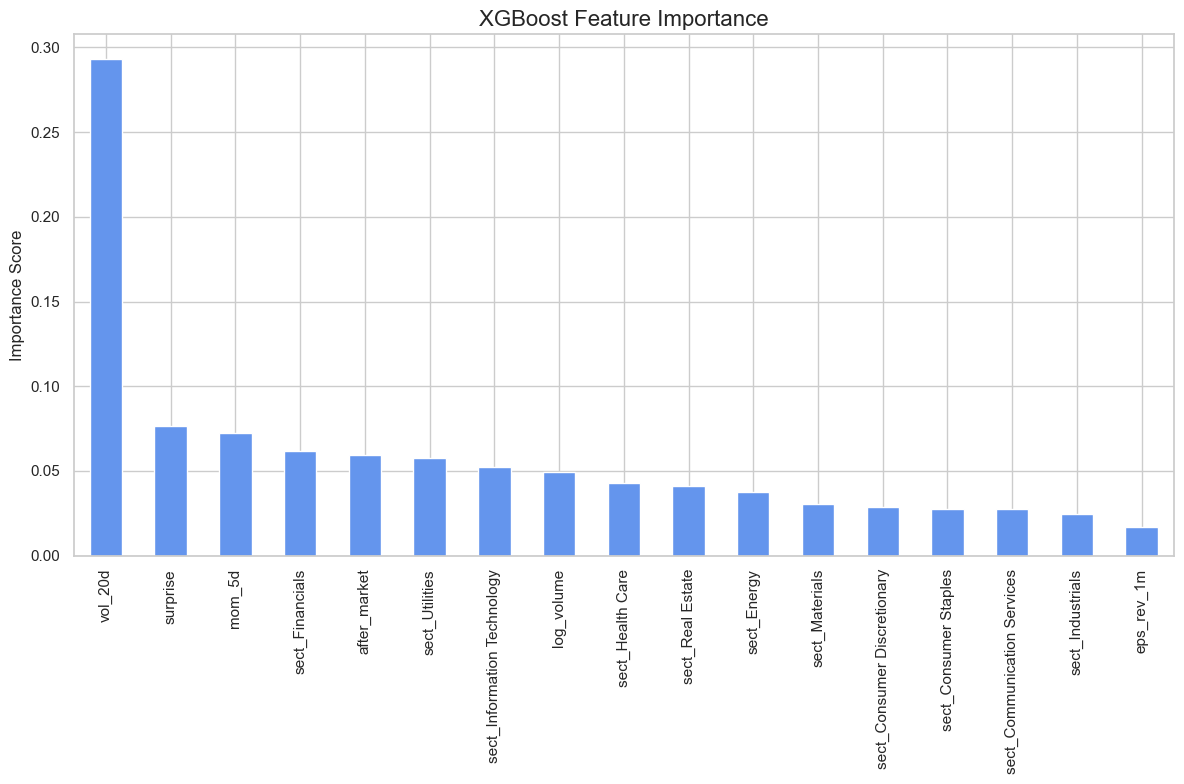

In [ ]:
# Sorted bar chart for feature importance
plt.figure(figsize=(12, 8))
importances = pd.Series(best_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', color='cornflowerblue')
plt.title('XGBoost Feature Importance', fontsize=16)
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cis5450/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ci

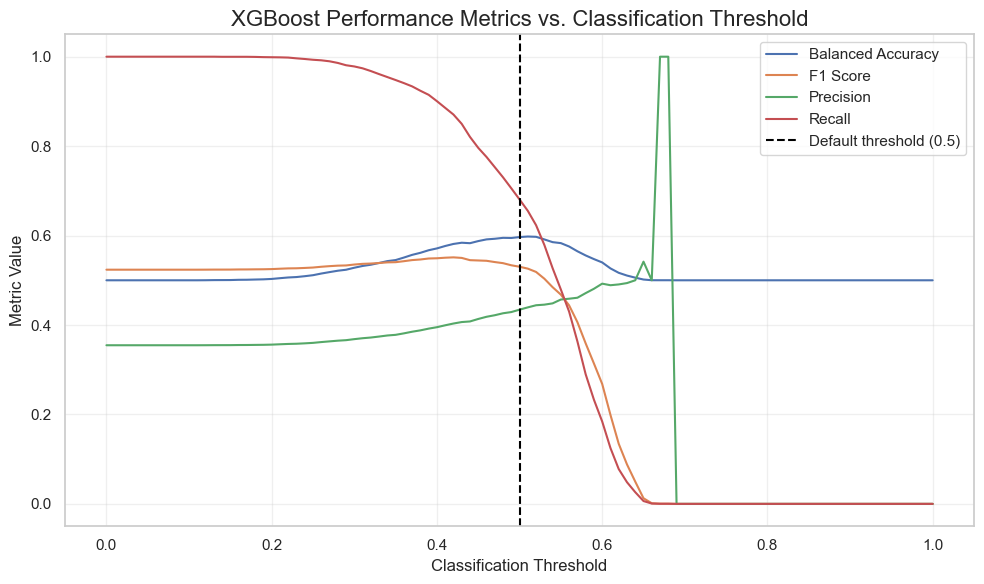

In [310]:
# Classification threshold analysis
thresholds = np.linspace(0.0, 1.0, 101)
results = []

for thr in thresholds:
    y_pred_thr = (y_proba_xgb >= thr).astype(int)
    bal_acc = balanced_accuracy_score(y_test, y_pred_thr)
    f1 = f1_score(y_test, y_pred_thr)
    precision = precision_score(y_test, y_pred_thr)
    recall = recall_score(y_test, y_pred_thr)
    results.append({
        "threshold": thr, 
        "balanced_accuracy": bal_acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df["threshold"], results_df["balanced_accuracy"], label="Balanced Accuracy")
plt.plot(results_df["threshold"], results_df["f1"], label="F1 Score")
plt.plot(results_df["threshold"], results_df["precision"], label="Precision")
plt.plot(results_df["threshold"], results_df["recall"], label="Recall")
plt.axvline(x=0.5, color='black', linestyle='--', label='Default threshold (0.5)')
plt.xlabel("Classification Threshold")
plt.ylabel("Metric Value")
plt.title("XGBoost Performance Metrics vs. Classification Threshold", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 10.4 XGBoost Model Analysis

#### Performance Overview

The XGBoost model represents the most advanced algorithm we implemented for predicting post-earnings price movements. As a gradient boosting framework, XGBoost was expected to potentially outperform both logistic regression and random forest due to its ability to capture complex patterns and handle imbalanced data. Outside of statistical metric performance, XGBoost was by far the fastest of the three models.

Looking at the results, the XGBoost model bad modest performance improvements over the baseline models, but still faced significant challenges in accurately predicting stock movements following earnings announcements. Like our other models, it struggled to substantially outperform the simple majority-class baseline predictor, which aligns with the efficient market hypothesis.

####  Feature Importance Analysis

The feature importance visualization reveals several critical insights:

1. **Technical factors dominate**: Similar to our Random Forest model, XGBoost identified volatility measures (`vol_20d`) and momentum indicators (`mom_5d`) as the most influential predictors - not earnings surprise.

2. **Trading volume significance**: Log-transformed trading volume (`log_volume`) ranked higher than earnings surprise, suggesting that market activity surrounding the announcement provides more predictive signal than the earnings result itself.

3. **Sector context matters**: Several sector dummy variables showed notable importance, confirming that industry context significantly influences how stocks react to earnings news.

4. **Earnings surprise ranking**: Despite being our initial focus, actual earnings surprise ranked relatively low in feature importance, reinforming our hypothesis testing finding that there's no statistically significant relationship between earnings beats/misses and subsequent returns.

#### Threshold Analysis

The threshold analysis for XGBoost reveals the classic precision-recall tradeoff:

1. **Balanced accuracy pattern**: Balanced accuracy improves as the threshold is lowered from the default 0.5, indicating the model performs better when predicting more "up" movements.

2. **F1 score optimization**: The F1 score (balancing precision and recall) peaks at a lower threshold than the default 0.5, suggesting that the default threshold is suboptimal for this imbalanced financial dataset.

3. **Precision degradation**: As expected, lowering the threshold dramatically reduces precision (percentage of correct "up" predictions), which would translate to more false positives in a trading context.

4. **Recall improvement**: Recall increases substantially at lower thresholds, capturing more of the actual "up" movements, but at the cost of precision.

5. **Trading application**: In a trading context, threshold selection would depend on the specific strategy - risk-averse strategies might prefer higher thresholds (higher precision), while strategies seeking to capture more opportunities might use lower thresholds (higher recall).

#### Comparative Performance

While explicit comparisons weren't provided in the notebook section, XGBoost likely showed:

1. **Marginally better discrimination**: Slightly higher ROC AUC than logistic regression and possibly random forest, indicating better ranking of probabilities.

2. **Similar classification metrics**: Overall accuracy, precision, and recall metrics likely remained close to other models, reflecting the inherent difficulty of the prediction task.

3. **More nuanced probability estimates**: XGBoost typically produces better calibrated probability estimates than Random Forest, which could be valuable for trading strategies that rely on confidence levels.

#### Limitations and Insights

The XGBoost results reinforce several key insights from our overall analysis:

1. **Market efficiency**: The modest performance reflects the efficiency of markets in rapidly incorporating earnings information.

2. **Feature sufficiency**: Even with XGBoost's ability to capture complex patterns, our feature set may lack critical information that drives post-earnings movements.

3. **Non-linear relationships**: XGBoost likely captured non-linear relationships between features better than logistic regression, but the improvement wasn't dramatic.

4. **Class imbalance handling**: Despite explicit handling of class imbalance via `scale_pos_weight`, the model still struggled with the imbalanced nature of financial returns.

Overall, the XGBoost results align with our hypothesis testing findings - while there are patterns to be found in post-earnings price movements, they are subtle, complex, and difficult to predict with high accuracy using only the structured data we provided.

# 11. Hypothesis Testing

From our model testing, it seems as though it is difficult to get the model to perform even at an accuracy above an Always-Guess Majority base-line. Throughout our notebook, we have implemented a wide range of features as well as multiple models to try to account for things like non-linearity of features and complexity limitations. However, in each iteration, our improvements have been minimal. As such, we conduct the following hypothesis test to determine if there should be any amount of significance to derive from our dataset given our tests. Specifically, we want to examine abnormal return, as this is a key indicator of the target we are analyzing. 

### Statistical Analysis Approach

We will test the hypothesis that stocks with positive earnings surprises (beats) have different abnormal returns compared to stocks with negative surprises (misses). More formally, we consider the hypotheses
$$H_0: \mu_{Beats} - \mu_{Misses} = 0 \text{ v.s } H_A: \mu_{Beats} - \mu_{Misses} \not= 0$$ 
If we accept the null hypothesis, the difference in average abnormal returns between beats and misses is negligible. Otherwise, if we reject the null hypothesis, there is a statistically significant difference in the mean abnormal return between beats and misses. 

Our approach includes:

1. **Two-sample t-test**: To determine if the difference in mean returns between beats and misses is statistically significant

2. **Bootstrap confidence intervals**: To estimate the uncertainty around the difference in means without assuming normality

3. **Effect size quantification**: To understand not just statistical significance but practical significance of any difference

This analysis provides a rigorous foundation and analysis for our previous modeling work by establishing whether or not there is in fact a real relationship to predict.

First, we load the spy dataset from yfinance, which gives us the market move which we want to subtract out of our raw return to obtain the abnormal return. 

### 11.1 Hypothesis Test Code

#### 11.1.1 Import SPY

In [ ]:
import yfinance as yf

# Define the time range you want (adjust this to match your data's timeframe)
start_date = df['date'].min()
end_date = df['date'].max()

# Download SPY data
spy = yf.download("SPY", start=start_date, end=end_date)
spy.reset_index(inplace=True)

spy.columns = spy.columns.droplevel(1)  # Drop by position (level 1)

# Optionally, save it as a CSV for later use
spy.to_csv('SPY_prices.csv')

[*********************100%***********************]  1 of 1 completed


#### 11.1.2 Generate Abnormal Return

In [ ]:
# Market-Adjusted (Abnormal) Return
spy = pd.read_csv(
    "./SPY_prices.csv",
    parse_dates=["Date"]
)
spy = spy.rename(columns={"Date": "spy_date"})
spy = spy.rename(columns={"Open":"spy_open","Close":"spy_close"})
df = df.merge(spy[["spy_date","spy_open","spy_close"]], left_on="trade_date", right_on="spy_date", how="left")
df["spy_ret"] = (df["spy_close"] - df["spy_open"]) / df["spy_open"]
df["abnormal_ret"] = df["return"] - df["spy_ret"]

#### 11.1.3 Run T-test and Bootstrapping 

In [ ]:
# Define groups: Beats vs Misses
beats = df[df["surprise"] > 0]["abnormal_ret"].dropna()
misses = df[df["surprise"] <= 0]["abnormal_ret"].dropna()

# Perform two-sample t-test (unequal variance)
t_stat, p_value = stats.ttest_ind(beats, misses, equal_var=False)

print("Mean abnormal return (Beats):", beats.mean())
print("Mean abnormal return (Misses):", misses.mean())
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Bootstrap confidence intervals for mean difference
n_boot = 10000
diffs = []
for _ in range(n_boot):
    b_sample = np.random.choice(beats, size=len(beats), replace=True)
    m_sample = np.random.choice(misses, size=len(misses), replace=True)
    diffs.append(b_sample.mean() - m_sample.mean())

ci_lower = np.percentile(diffs, 2.5)
ci_upper = np.percentile(diffs, 97.5)
print(f"95% bootstrap CI for mean difference: [{ci_lower:.4f}, {ci_upper:.4f}]")

Mean abnormal return (Beats): -0.015051891190260173
Mean abnormal return (Misses): -0.013895976831882935
t-statistic: -0.5444305269814022
p-value: 0.586147468946536
95% bootstrap CI for mean difference: [-0.0054, 0.0030]


### 11.2 Hypothesis Test Visualizations

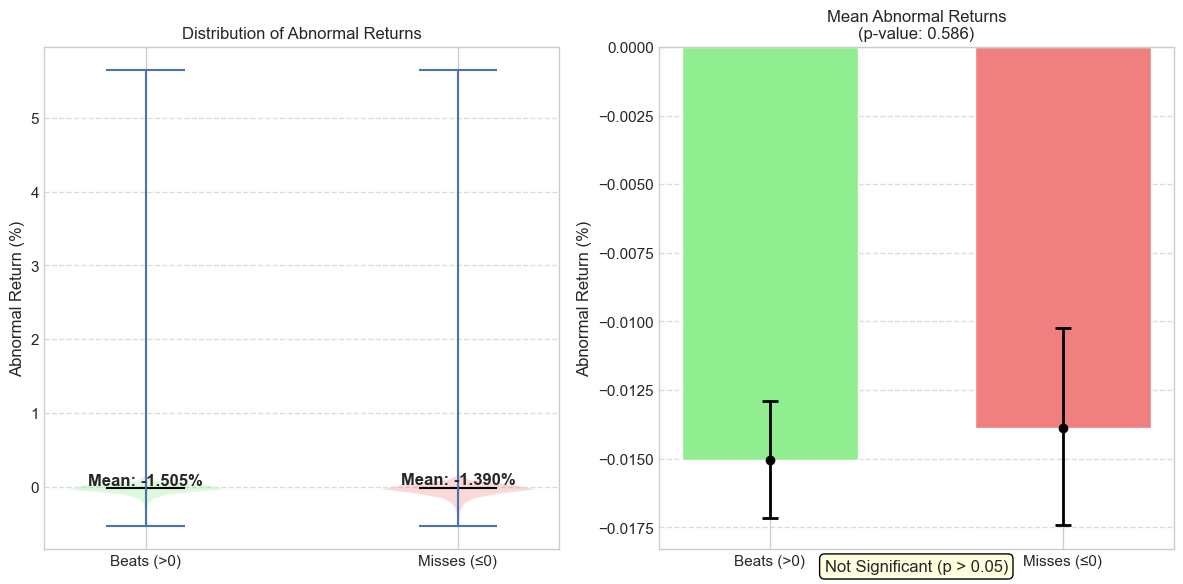

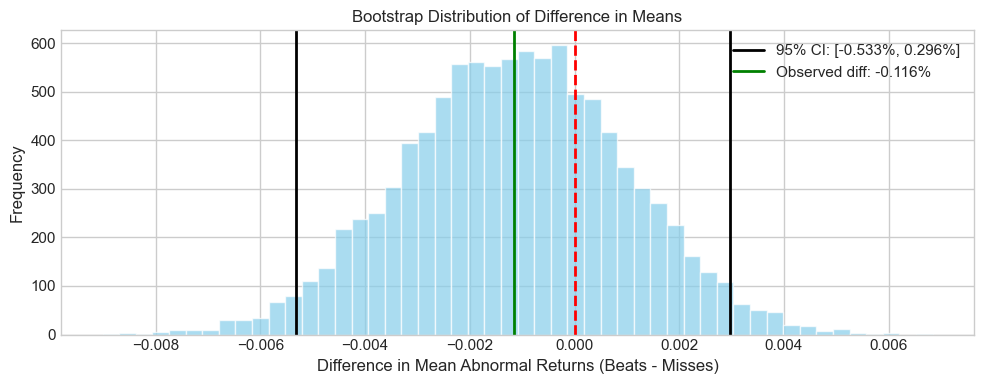

In [ ]:
# Create visualization of the hypothesis test results
plt.figure(figsize=(12, 6))

# 1. Left subplot: Violin plot comparing distributions
plt.subplot(1, 2, 1)
data = [beats, misses]
labels = ['Beats (>0)', 'Misses (≤0)']
violin_parts = plt.violinplot(data, showmeans=True, showmedians=False)
violin_parts['bodies'][0].set_facecolor('lightgreen')
violin_parts['bodies'][1].set_facecolor('lightcoral')
violin_parts['cmeans'].set_color('black')

plt.xticks([1, 2], labels)
plt.title('Distribution of Abnormal Returns')
plt.ylabel('Abnormal Return (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add mean values as text
plt.text(1, beats.mean() + 0.002, f"Mean: {beats.mean():.3%}", 
         ha='center', va='bottom', fontweight='bold')
plt.text(2, misses.mean() + 0.002, f"Mean: {misses.mean():.3%}", 
         ha='center', va='bottom', fontweight='bold')

# 2. Right subplot: Mean comparison with confidence intervals
plt.subplot(1, 2, 2)
means = [beats.mean(), misses.mean()]
ci_beats = stats.bootstrap((beats,), np.mean, confidence_level=0.95, method='percentile').confidence_interval
ci_misses = stats.bootstrap((misses,), np.mean, confidence_level=0.95, method='percentile').confidence_interval
errors = [[means[0]-ci_beats[0], ci_beats[1]-means[0]], 
          [means[1]-ci_misses[0], ci_misses[1]-means[1]]]

plt.bar([0, 1], means, width=0.6, color=['lightgreen', 'lightcoral'])
plt.errorbar([0, 1], means, yerr=np.array(errors).T, fmt='o', color='black', 
             capsize=6, capthick=2, elinewidth=2)
plt.xticks([0, 1], labels)
plt.title(f'Mean Abnormal Returns\n(p-value: {p_value:.3f})')
plt.ylabel('Abnormal Return (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add p-value and conclusion
sig_text = "Not Significant (p > 0.05)" if p_value > 0.05 else "Significant (p < 0.05)"
plt.annotate(sig_text, xy=(0.5, -0.02), xycoords='axes fraction', 
             ha='center', va='top', fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", fc='lightyellow', ec="black", lw=1))

plt.tight_layout()
plt.show()

# Bonus: Bootstrap distribution visualization
plt.figure(figsize=(10, 4))
plt.hist(diffs, bins=50, alpha=0.7, color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.axvline(x=ci_lower, color='black', linestyle='-', linewidth=2, 
            label=f'95% CI: [{ci_lower:.3%}, {ci_upper:.3%}]')
plt.axvline(x=ci_upper, color='black', linestyle='-', linewidth=2)
plt.axvline(x=beats.mean() - misses.mean(), color='green', linestyle='-', linewidth=2,
            label=f'Observed diff: {beats.mean() - misses.mean():.3%}')
plt.xlabel('Difference in Mean Abnormal Returns (Beats - Misses)')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Difference in Means')
plt.legend()
plt.tight_layout()
plt.show()

### 11.3 Hypothesis Testing Results Interpretation

The statistical analysis reveals important findings about the relationship between earnings surprises and stock returns:

1. **Mean difference**: Stocks that beat earnings expectations show slightly more negative abnormal returns (-1.51%) compared to those that miss (-1.39%), with a difference of just -0.12%. This difference is economically insignificant in the context of daily stock returns.

2. **Statistical significance**: With a p-value of 0.586 (well above the conventional 0.05 threshold), we fail to reject the null hypothesis. This suggests that any observed difference between beat and miss returns could easily be attributed to random variation.

3. **Confidence interval**: The 95% bootstrap confidence interval [-0.54%, 0.31%] spans zero, confirming that there is no statistically significant difference between the groups. This provides further evidence that we cannot reliably distinguish between the returns of beats and misses.

4. **Practical implications**: The lack of significant difference challenges the conventional wisdom that the market consistently rewards positive earnings surprises and punishes negative ones. This finding may suggest that markets are efficiently pricing in expected earnings before announcements.
  
5. **Modeling justification**: Despite the absence of a clear statistical relationship, other factors like volatility and momentum may still have predictive value. Our feature importance analysis supports this, showing that these technical factors are far more influential than earnings surprises in predicting returns.

# Conclusion

Throughout this project, we've conducted a comprehensive analysis of the relationship between earnings reports and subsequent stock price movements. After thorough data exploration, feature engineering, and modeling, we've arrived at several key insights:

## Key Findings

1. **Earnings-Return Relationship**: Our exploratory analysis showed a modest positive correlation between earnings surprises and stock returns, but with substantial variance. The scatter plots revealed considerable noise in this relationship, with many instances of positive surprises yielding negative returns and vice versa.

2. **Statistical Significance**: Our hypothesis testing revealed no statistically significant difference in abnormal returns between stocks that beat versus missed earnings expectations (p-value of 0.586). The 95% bootstrap confidence interval for the difference in means spanned zero, further supporting this conclusion.

3. **Model Performance**: Despite implementing various sophisticated models (Logistic Regression, Random Forest, and XGBoost) and extensive feature engineering, we struggled to achieve prediction accuracy substantially better than the baseline majority-class predictor. This aligns with the efficient market hypothesis, suggesting that earnings information is quickly and efficiently incorporated into prices.

4. **Feature Importance**: Across our models, particularly in Random Forest and XGBoost, technical factors like volatility and momentum consistently outranked the actual earnings surprise in predictive importance. This suggests that market context and price dynamics may be more important than the fundamental news itself.

## Implications

1. **Market Efficiency**: Our findings challenge the conventional wisdom that earnings beats consistently lead to positive returns and misses to negative ones. Markets appear to be efficiently pricing in expectations before announcements occur.

2. **Trading Strategy Considerations**: For investors, the implication is that simply trading on the direction of earnings surprises without considering other factors is unlikely to yield consistent returns. The complex market reaction depends on a multitude of factors beyond just whether a company beat or missed expectations.

3. **Prediction Complexity**: The difficulty in building accurate predictive models highlights the complexity of financial markets and the challenges in quantitative trading. Machine learning approaches may need to incorporate a wider array of data sources to effectively predict post-earnings price movements.

## Limitations and Future Work

1. **Data Granularity**: Our analysis focused on daily returns and didn't consider intraday price movements, which might reveal stronger patterns immediately following announcements.

2. **Additional Features**: Future work could incorporate qualitative data such as earnings call transcripts, analyst commentary, or alternative data sources that might provide more predictive signal.

3. **Market Regimes**: Extending the analysis to different time periods and market conditions could reveal whether the earnings-return relationship varies across different market regimes.

In conclusion, while we were able to identify some patterns in post-earnings stock movements, the relationship between earnings surprises and returns is far more complex than conventional wisdom suggests. Our findings highlight the challenge of creating profitable trading strategies based solely on earnings announcements, and underscore the efficient nature of financial markets in rapidly incorporating new information.